# **AI for Trees - Data subteam**
# *Task:* Data Augmentation

The team task is to do data enrichment for the challenge. This notebook explores data augmentation for the purpose of making more data available that can be used by other teams. It looks at the implementation of different data augmentation techniques and various preprocessing methods, making use of TensorFlow.

(Note: So far all methods only implemented on one example image.)

In [5]:
# Connect directory to notebook and navigate to where data is stored

# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# path to data within drive
DATA_path = '/content/drive/MyDrive/AI for Trees Share/01. Data'

Mounted at /content/drive


In [6]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [7]:
# Import all needed modules
import matplotlib.pyplot as plt
import cv2
import numpy
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import json
from matplotlib.patches import Rectangle

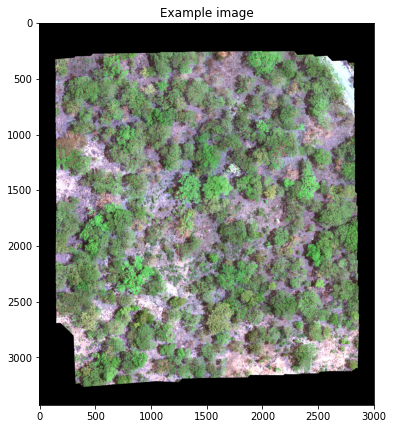

In [20]:
# Working with example image (RGB)

# path to selected image
img_path = DATA_path +'/2021/img/ZK17.tif'

# read in image and display
img_array = cv2.imread(img_path)
plt.figure(figsize=(6, 8))
plt.title("Example image")
plt.imshow(img_array)

# Preprocessing

Use TensorFlow to extract patches from an image:

`tf.image_extract_patches()` (https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) results in a 4D tensor indexed by batch, row, column.

You can control if the patches overlap or not in the image by using the `stride`.

The **dimension of the output tensor** is `[batch, out_rows, out_cols, patch_rows * patch_cols * depth]` (in this case [1, out_rows, out_cols, patch_size * patch_size * 3]).

'VALID' padding ensures only patches that are fully contained in the input image are included. For 'SAME' padding, all patches whose starting point is inside the input are included and areas outside the input default to zero.

We start by splitting the original image into patches:

In [ ]:
# Function for extracting image patches

def extractPatches(image, patch_size, num_strides):
  ''' Extracting square image patches from one input image.
      returns: array of patches and total number of patches '''
  r, c, d = image.shape
  # reshape image to 4D tensor
  I = np.reshape(image, (1, r, c, d))
  p = tf.image.extract_patches(images=I, sizes=[1, patch_size, patch_size, 1], strides=[1, num_strides, num_strides, 1], rates=[1, 1, 1, 1], padding='SAME')
  P = p.numpy(); sh = P.shape; num_patches = np.int((sh[1]*sh[2]))
  # get numpy array of size (number of patches, patch size, patch size)
  patches = np.reshape(P, (num_patches, patch_size, patch_size, 3))
  return patches, num_patches
        

In [ ]:
patches, num_patches = extractPatches(image=img_array, patch_size=450, num_strides=450)
# print(num_patches)

In [ ]:
# Display some example patches

rows = 8; cols = 7
fig = plt.figure(figsize=(18, 18))
for i in range(1, num_patches+1):
    img = patches[i-1, :, :, :]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Get rid of unnecessary (black) background pixels

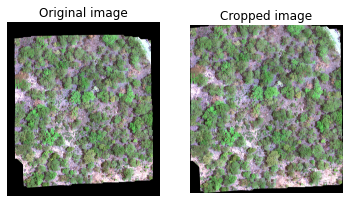

In [36]:
r, c, d = img_array.shape
# (most likely there is a more efficient way of implementing this)
# keep track of first row that contains image data
top = None
left = None
right = None
bottom = None
# bottom space
for i in range(r):
    for j in range(c):
        if img_array[i][j].all() != 0:
            bottom = i
            break
# top space
for i in range(r-1, 0, -1):
    for j in range(c):
        if img_array[i][j].all() != 0:
            top = i
            break
# right space
for i in range(c):
    for j in range(r):
        if img_array[j][i].all() != 0:
            right = i
            break
# left space
for i in range(c-1, 0, -1):
    for j in range(r):
        if img_array[j][i].all() != 0:
            left = i
            break
# crop image
cropped = img_array[top:bottom, left:right]

fig = plt.figure()
plt.subplot(1, 2, 1); plt.title('Original image'); plt.axis('off'); plt.imshow(img_array)
plt.subplot(1,2,2); plt.title('Cropped image'); plt.axis('off'); plt.imshow(cropped)

Getting rid of the tiles that contain a lot of the black background as only tiles that contain majority trees should be used for training.

In [ ]:
n, r, c, d = patches.shape
final_patches = []

# set threshold for what patches to consider 
# (can be changed/should decide on an optimal threshold to use)
threshold = 20

for patch in patches:
  sum = 0
  r, c, d = patch.shape
  # calculate % of solid black pixels in tile
  for i in range(r):
    for j in range(c):
      if patch[i][j].all() == 0:
        sum += 1
  total_percentage = sum/(r*c)*100
  if total_percentage < threshold:
    final_patches.append(patch)
  
# format patches into array (not list)
train_patches = np.zeros((len(final_patches), r, c, d))
for i in range(len(final_patches)):
  train_patches[i, :, :, :] = final_patches[i]
train_patches = train_patches.astype(int)

total_num_patches = train_patches.shape[0]

In [ ]:
# Display final example patches to use in training model

rows = 6; cols = 5
fig = plt.figure(figsize=(15, 15))
for i in range(1, total_num_patches+1):
    img = train_patches[i-1, :, :, :]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Implement data augmentations

In [ ]:
# Function to visualise and compare original and augmented images side by side
def visualise(original, augmented, title):
  fig = plt.figure()
  fig.suptitle(title)
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.axis('off')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.axis('off')
  plt.imshow(augmented)

In [ ]:
# RESIZE IMAGE
# resized_img = tf.image.resize(img_array, [500,500])

# FLIP IMAGE VERTICALLY
flip_vertical = tf.image.flip_up_down(img_array)

# FLIP IMAGE HORIZONTALLY
flip_horizontal = tf.image.flip_left_right(img_array)

# ROTATE THROUGH SPECIFIED ANGLE IN RADIANS
rotate = tfa.image.rotate(img_array, tf.constant(np.pi/2))

# VIEW AUGMENTATIONS
fig = plt.figure(figsize=(18, 18))
rows = 1; cols = 4
fig.add_subplot(rows, cols, 1); plt.imshow(img_array); plt.title("Original image"); plt.axis('off')
fig.add_subplot(rows, cols, 2); plt.imshow(flip_vertical); plt.title("Flipped vertically"); plt.axis('off')
fig.add_subplot(rows, cols, 3); plt.imshow(flip_horizontal); plt.title("Flipped horizontally"); plt.axis('off')
fig.add_subplot(rows, cols, 4); plt.imshow(rotate); plt.title("Rotated 90°"); plt.axis('off')
plt.show()

# Colour augmentations

**IN PROGRESS**

It is likely that there will be colour variation in the trees across different images as well as even between trees in the same image, so it can be useful to apply colour augmentations to the training data.

These methods adjust the image by a certain **user-specified factor**

In [ ]:
# Adjust brightness (in range(-1, 1))
brightened = tf.image.adjust_brightness(img_array, 0.3)
visualise(img_array, brightened, "Brighten")

# Adjust saturation (given float)
saturated = tf.image.adjust_saturation(img_array, 0.4)
visualise(img_array, saturated, "Saturate")

# Adjust contrast (given a float multiplier)
alt_contrast = tf.image.adjust_contrast(img_array, 2.0)
visualise(img_array, alt_contrast, "Adjust Contrast")

These methods adjust the image qualities by a **random factor** (picked in an interal)

In [ ]:
# Give only max value delta can take on
brightened = tf.image.random_brightness(img_array, max_delta=0.2)
visualise(img_array, brightened, "Brighten")
# Give in lower and upper bound for the saturation factor
saturated = tf.image.random_saturation(img_array, 1, 5)
visualise(img_array, saturated, "Saturate")
# Give in lower and upper bound for random contrast factor
contrasted = tf.image.random_contrast(img_array, 0.2, 0.5)
visualise(img_array, contrasted, "Adjust Contrast")

Other augmentation options:

- Sharpening
- Blurring
- Cropping
- Use of GANs for augmentation using DL (not necessarily recommended but is an option)
- Use colour transfer to augment colour of images (but need a reference image to map images to and method can be sensitive to this choice of reference image but its another option)

# Work with data annotations

### Working with the geojson files

**IN** **PROGRESS**

Current problem: The geojson file is at a different scale to the image, how to match pixel locations to the coordinates given to ensure the segmentation match is correct?

First, we need to install the necessary libraries and import modules:

In [2]:
pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.2 MB/s 
     |████████████████████████████████| 6.3 MB 40.3 MB/s 
     |████████████████████████████████| 16.7 MB 458 kB/s 


In [4]:
pip install osgeo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
    Running setup.py install for osgeo ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-whlkij8c/osgeo_6254b4a248a44638a3995344cbd0d73d/setup.py'"'"'; __file__='"'"'/tmp/pip-install-whlkij8c/osgeo_6254b4a248a44638a3995344cbd0d73d/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-l3zlq1gd/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/osgeo Check the logs for full comman

In [25]:
# import needed modules
import geojson
import geopandas as gpd
from geojson import Polygon
from osgeo import gdal
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO

We can view the original labels given for the image:

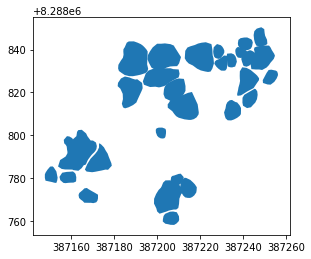

In [10]:
# get example image file
file_path = DATA_path + '/2021/shp/ZK17/ZK17.geojson'
df_shapes = gpd.read_file(file_path)

# view the first geometry index (first shape)
# df_shapes['geometry'][0]

# view all shapes in file
df_shapes.plot()

Next, we will take a look at the updated labels given to us by cfru.ti:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

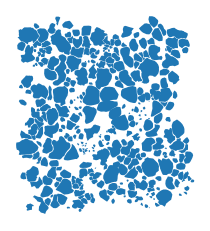

In [17]:
# view updated labels

new_file = '/content/drive/MyDrive/AI for Trees Share/Data to be Labeled/cfru.ti labeled/ZK17.geojson'

new_shapes = gpd.read_file(new_file)
new_shapes.plot()
plt.axis('off')
plt.savefig('mask.jpg', bbox_inches='tight')
files.download('mask.jpg') 

In [ ]:
# display spatial information
# print(gdal.Info(DATA_path +'/2021/img/ZK17.tif'))

# extract pixel size and starting coordinates
geo = gdal.Open(DATA_path +'/2021/img/ZK17.tif')
info = geo.GetGeoTransform()
origin = [info[0], info[3]]
pixel_size = [info[1], info[5]]
print(f"Origin: {origin}")
print(f"Pixel size (x, y): {pixel_size}")

Origin: [387115.1487, 8288917.8458]
Pixel size (x, y): [0.055381724367495014, -0.05538172262781946]


           ID Height CrwnRd                                           geometry
0      ZK17_1   None   None  POLYGON ((387195.668 8288839.064, 387195.412 8...
1      ZK17_2   None   None  POLYGON ((387208.065 8288841.420, 387211.190 8...
2      ZK17_3   None   None  POLYGON ((387210.114 8288830.714, 387210.524 8...
3      ZK17_4   None   None  POLYGON ((387193.056 8288824.465, 387193.312 8...
4      ZK17_5   None   None  POLYGON ((387210.165 8288826.514, 387212.522 8...
..        ...    ...    ...                                                ...
322  ZK17_323   None   None  POLYGON ((387177.254 8288823.844, 387176.399 8...
323  ZK17_324   None   None  POLYGON ((387178.815 8288825.287, 387178.550 8...
324  ZK17_325   None   None  POLYGON ((387175.309 8288832.637, 387174.809 8...
325  ZK17_326   None   None  POLYGON ((387258.382 8288784.458, 387256.850 8...
326  ZK17_327   None   None  POLYGON ((387163.526 8288899.287, 387162.466 8...

[327 rows x 4 columns]


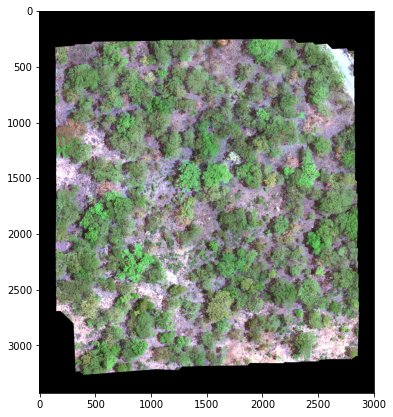

In [35]:
# view segmentation labels on image

# base image
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_array)

# new_shapes.plot(ax=ax)
print(new_shapes)
plt.show()